# Modelling:
- This notebook uses the data obtained from Pre-Processing notebook

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import librosa
import multiprocessing as mp
import re
import pickle
import time

In [2]:
# Random Seed for Reproducibility
tf.keras.utils.set_random_seed(442)

In [3]:
# GPU Usage
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# Set memory growth
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

Num GPUs Available:  1


2022-05-21 21:46:52.464299: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-21 21:46:52.506712: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-21 21:46:52.506803: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
labeldict = {
    'Sadness': 0,
    'Excited': 1,
    'Happiness': 2,
    'Anger' : 3,
    'Frustration' : 4,
    'Other' : 5
}

In [5]:
def one_hot_encode(label):
    one_hot = np.zeros(6)
    one_hot[labeldict[label]] = 1
    return one_hot

In [6]:
def one_hot_encode_list(listOfLabels):
    finalList = []
    for label in listOfLabels:
        finalList.append(one_hot_encode(label))
    return np.array(finalList)

In [7]:
def get_STFT_and_label(path):
    emotion = re.match('.*/DATA/([a-zA-Z]+)/.*', path).groups()[0]
    data, _ = librosa.load(path, sr=44100)
    STFT = np.abs(librosa.stft(data))
    return STFT, emotion

In [8]:
def preprocess_input(pathList): # Returns a list of x (batch_size, timesteps, feature), y (one_hot_encoded)
    with mp.Pool() as p:
        results = p.map(get_STFT_and_label, pathList)
    # Preprocess x:
    x = [item[0] for item in results]
    # Flatten
    x = [item for sublist in x for item in sublist]
    # Zero-padding:
    x = keras.preprocessing.sequence.pad_sequences(x, padding="post", maxlen=1497, dtype = np.float32) # maxlen is after discovering the whole training data
    # Reshaping so that the order is not messed up
    x = x.reshape(-1, 1025, 1497)
    # Transposing so that we have timesteps in dim 1
    x = x.transpose((0, 2, 1))
    # Preprocess y:
    y = [item[1] for item in results]
    # one_hot_encode
    y = one_hot_encode_list(y)
    return x, y

# Loading data: 
- We will load the data per predefined batch size, this is to reduce the memory used for training:

In [9]:
with open('train_paths.pkl', 'rb') as f:
    train_paths = pickle.load(f)
with open('test_paths.pkl', 'rb') as f:
    test_paths = pickle.load(f)

In [10]:
# Make batches of the pathList:
def create_batches(pathList, batch_size):
    ansList = [] # To store the final batched paths
    tempList = [] # Temporary list
    count = 0
    while count < len(pathList):
        tempList.append(pathList[count]) # Append the path
        count += 1
        if (count % batch_size) == 0: # if count is a multiple of batch_size
            ansList.append(tempList)
            tempList = []
    if len(tempList) != 0: # If tempList is not empty
        ansList.append(tempList) # Append the remaining values
    return ansList

In [11]:
# Load the validation datasets. The validation datasets are loaded entirely to the machine.
x_val, y_val = preprocess_input(test_paths)

In [12]:
x_val.shape

(1200, 1489, 1025)

# Modelling:

In [13]:
# Keras API:
inp = layers.Input(shape=(None, 1025))
x = layers.Masking(mask_value=0.0)(inp)
total_seq, final_hidden_state, final_cell_state = layers.LSTM(256, return_state=True)(x)
x = layers.Dense(512, activation='relu')(final_hidden_state)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(6, activation='softmax')(x)

model = keras.Model(inp, x)

2022-05-21 22:00:20.048090: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-21 22:00:20.049762: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-21 22:00:20.049956: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-21 22:00:20.050078: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 1025)]      0         
                                                                 
 masking (Masking)           (None, None, 1025)        0         
                                                                 
 lstm (LSTM)                 [(None, 256),             1312768   
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
 dense (Dense)               (None, 512)               131584    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896 

# Training the model

In [15]:
# Batch_size is 32, epochs = 30
batch_size = 32
epochs = 30

In [16]:
# Optimizer is Stochastic Gradient Descent
# Loss function is Categorical Crossentropy
optimizer = keras.optimizers.SGD()
loss_fn = keras.losses.CategoricalCrossentropy()

In [17]:
training_batch = create_batches(train_paths, batch_size=batch_size)
validation_batch = create_batches(test_paths, batch_size=batch_size)

In [18]:
# Metrics:
train_metrics = tf.keras.metrics.CategoricalAccuracy()
validation_metrics = tf.keras.metrics.CategoricalAccuracy()
train_loss = tf.keras.metrics.CategoricalCrossentropy()
validation_loss = tf.keras.metrics.CategoricalCrossentropy()

In [19]:
# A list to store epoch results:
epoch_accuracy_train = []
epoch_accuracy_val = []
epoch_loss_train = []
epoch_loss_val = []

In [20]:
# To speed up, use graph execution
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        y_pred = model(x, training = True)
        loss = loss_fn(y, y_pred)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    # Update training accuracy
    train_metrics.update_state(y, y_pred)
    # Update training loss:
    train_loss.update_state(y, y_pred)
    return loss

In [21]:
@tf.function
def valid_step(x, y):
    y_val_pred = model(x, training=False)
    # Update metrics for validation
    validation_metrics.update_state(y, y_val_pred)
    validation_loss.update_state(y, y_val_pred)
    return

In [22]:
# Custom Training loop:
for epoch in range(epochs):
    start_time = time.time()
    print("\nStart of epoch %d" % (epoch))
    for step, batch in enumerate(training_batch):
        x, y = preprocess_input(batch)
        
        loss = train_step(x, y)
        
        # Log every 200 batches.
        if step % 10 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss))
            )
            print("Seen so far: %d samples" % ((step + 1) * batch_size))
    
    # Display metrics at the end of each epoch.
    train_acc = train_metrics.result()
    print("Training acc over epoch: %.4f" % (float(train_acc)))
    loss_train = train_loss.result()
    print("Training loss over epoch: %.4f" % (float(loss_train)))
    
    # Reset training metrics at the end of each epoch
    train_metrics.reset_states()
    train_loss.reset_states()
    
    # For validation data:
    for val_batch in validation_batch:
        x_val, y_val = preprocess_input(val_batch)
        
        valid_step(x_val, y_val)
        

    # Metrics
    val_acc = validation_metrics.result()
    loss_val = validation_loss.result()
    validation_metrics.reset_states()
    validation_loss.reset_states()
    
    # Append to a list for graph:
    epoch_accuracy_train.append(train_acc)
    epoch_accuracy_val.append(val_acc)
    epoch_loss_train.append(loss_train)
    epoch_loss_val.append(loss_val)
    
    print("Validation acc: %.4f" % (float(val_acc)))
    print("Validation loss: %.4f" % (float(loss_val)))
    print("Time taken: %.2fs" % (time.time() - start_time))



Start of epoch 0


2022-05-21 22:00:46.502635: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2022-05-21 22:00:46.633603: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Training loss (for one batch) at step 0: 1.7829
Seen so far: 32 samples
Training loss (for one batch) at step 10: 1.7884
Seen so far: 352 samples
Training loss (for one batch) at step 20: 1.7899
Seen so far: 672 samples
Training loss (for one batch) at step 30: 1.7747
Seen so far: 992 samples
Training loss (for one batch) at step 40: 1.7946
Seen so far: 1312 samples
Training loss (for one batch) at step 50: 1.8121
Seen so far: 1632 samples
Training loss (for one batch) at step 60: 1.7827
Seen so far: 1952 samples
Training loss (for one batch) at step 70: 1.7912
Seen so far: 2272 samples
Training loss (for one batch) at step 80: 1.7901
Seen so far: 2592 samples
Training loss (for one batch) at step 90: 1.7842
Seen so far: 2912 samples
Training loss (for one batch) at step 100: 1.7758
Seen so far: 3232 samples
Training loss (for one batch) at step 110: 1.7939
Seen so far: 3552 samples
Training loss (for one batch) at step 120: 1.7759
Seen so far: 3872 samples
Training loss (for one batch

Training loss (for one batch) at step 80: 1.7042
Seen so far: 2592 samples
Training loss (for one batch) at step 90: 1.7184
Seen so far: 2912 samples
Training loss (for one batch) at step 100: 1.7025
Seen so far: 3232 samples
Training loss (for one batch) at step 110: 1.7451
Seen so far: 3552 samples
Training loss (for one batch) at step 120: 1.7585
Seen so far: 3872 samples
Training loss (for one batch) at step 130: 1.7235
Seen so far: 4192 samples
Training loss (for one batch) at step 140: 1.6971
Seen so far: 4512 samples
Training acc over epoch: 0.2883
Training loss over epoch: 1.7129
Validation acc: 0.2942
Validation loss: 1.7333
Time taken: 377.24s

Start of epoch 7
Training loss (for one batch) at step 0: 1.6769
Seen so far: 32 samples
Training loss (for one batch) at step 10: 1.7854
Seen so far: 352 samples
Training loss (for one batch) at step 20: 1.7116
Seen so far: 672 samples
Training loss (for one batch) at step 30: 1.6634
Seen so far: 992 samples
Training loss (for one bat

Validation acc: 0.2733
Validation loss: 1.7008
Time taken: 381.18s

Start of epoch 13
Training loss (for one batch) at step 0: 1.6334
Seen so far: 32 samples
Training loss (for one batch) at step 10: 1.8169
Seen so far: 352 samples
Training loss (for one batch) at step 20: 1.6228
Seen so far: 672 samples
Training loss (for one batch) at step 30: 1.5836
Seen so far: 992 samples
Training loss (for one batch) at step 40: 1.6368
Seen so far: 1312 samples
Training loss (for one batch) at step 50: 1.8109
Seen so far: 1632 samples
Training loss (for one batch) at step 60: 1.6657
Seen so far: 1952 samples
Training loss (for one batch) at step 70: 1.7355
Seen so far: 2272 samples
Training loss (for one batch) at step 80: 1.5586
Seen so far: 2592 samples
Training loss (for one batch) at step 90: 1.7388
Seen so far: 2912 samples
Training loss (for one batch) at step 100: 1.5990
Seen so far: 3232 samples
Training loss (for one batch) at step 110: 1.7599
Seen so far: 3552 samples
Training loss (for

Training loss (for one batch) at step 70: 1.5892
Seen so far: 2272 samples
Training loss (for one batch) at step 80: 1.5230
Seen so far: 2592 samples
Training loss (for one batch) at step 90: 1.6297
Seen so far: 2912 samples
Training loss (for one batch) at step 100: 1.5222
Seen so far: 3232 samples
Training loss (for one batch) at step 110: 1.6639
Seen so far: 3552 samples
Training loss (for one batch) at step 120: 1.6581
Seen so far: 3872 samples
Training loss (for one batch) at step 130: 1.5791
Seen so far: 4192 samples
Training loss (for one batch) at step 140: 1.5454
Seen so far: 4512 samples
Training acc over epoch: 0.3640
Training loss over epoch: 1.5385
Validation acc: 0.3083
Validation loss: 1.6169
Time taken: 380.08s

Start of epoch 20
Training loss (for one batch) at step 0: 1.5236
Seen so far: 32 samples
Training loss (for one batch) at step 10: 1.7193
Seen so far: 352 samples
Training loss (for one batch) at step 20: 1.5752
Seen so far: 672 samples
Training loss (for one b

Training acc over epoch: 0.3550
Training loss over epoch: 1.5506
Validation acc: 0.3083
Validation loss: 1.6589
Time taken: 379.20s

Start of epoch 26
Training loss (for one batch) at step 0: 1.5774
Seen so far: 32 samples
Training loss (for one batch) at step 10: 1.8466
Seen so far: 352 samples
Training loss (for one batch) at step 20: 1.5616
Seen so far: 672 samples
Training loss (for one batch) at step 30: 1.4898
Seen so far: 992 samples
Training loss (for one batch) at step 40: 1.4533
Seen so far: 1312 samples
Training loss (for one batch) at step 50: 1.6791
Seen so far: 1632 samples
Training loss (for one batch) at step 60: 1.6061
Seen so far: 1952 samples
Training loss (for one batch) at step 70: 1.6790
Seen so far: 2272 samples
Training loss (for one batch) at step 80: 1.5020
Seen so far: 2592 samples
Training loss (for one batch) at step 90: 1.6607
Seen so far: 2912 samples
Training loss (for one batch) at step 100: 1.4426
Seen so far: 3232 samples
Training loss (for one batch)

# Plotting:

In [23]:
import matplotlib.pyplot as plt

In [24]:
axis_x = [i+1 for i in range(epochs)]

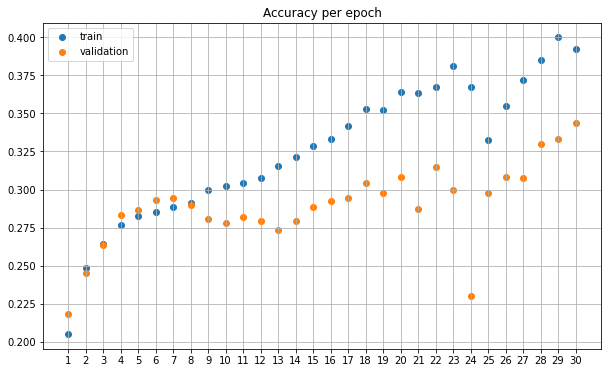

In [25]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(x = axis_x, y = epoch_accuracy_train, label = "train")
ax.scatter(x = axis_x, y = epoch_accuracy_val, label="validation")
ax.legend()
ax.grid()
ax.set_title("Accuracy per epoch")
ax.set_xticks(ticks = axis_x)
plt.show()

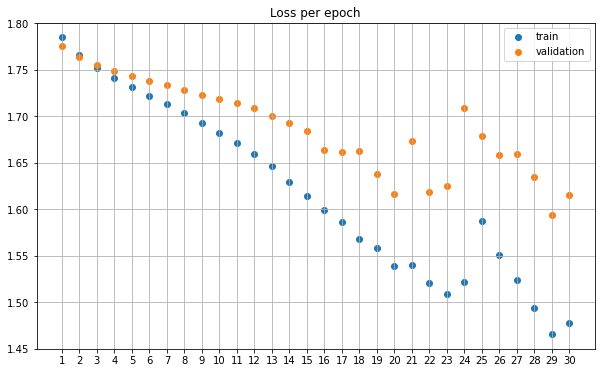

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x = axis_x, y = epoch_loss_train, label="train")
ax.scatter(x = axis_x, y = epoch_loss_val, label="validation")
ax.legend()
ax.grid()
ax.set_title("Loss per epoch")
ax.set_xticks(ticks = axis_x)
plt.show()